In [1]:
# imports
import torch
import json
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# figure aesthetics
# plt.style.use(['dark_background','seaborn-notebook'])  # for dark themes
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])
# plt.style.use(['seaborn-notebook'])

In [3]:
root = Path('..')

# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
# print(f"{sys.executable = }")

# from sf_nets.utils import spaths, dmaps
import sf_nets.models as models
import sf_nets.datasets as datasets
from sf_nets.utils.mpl_utils import coord_grid

# Dataset

In [4]:
name_ds = 'Parab3'

In [5]:
dataset = getattr(datasets, name_ds)
data_path = root / 'data' / name_ds
model_path = root / 'results' / 'models' / name_ds.lower()

## Path

In [6]:
times, path = torch.load(data_path / 'raw' / 'path.pt')
len(path)

66668

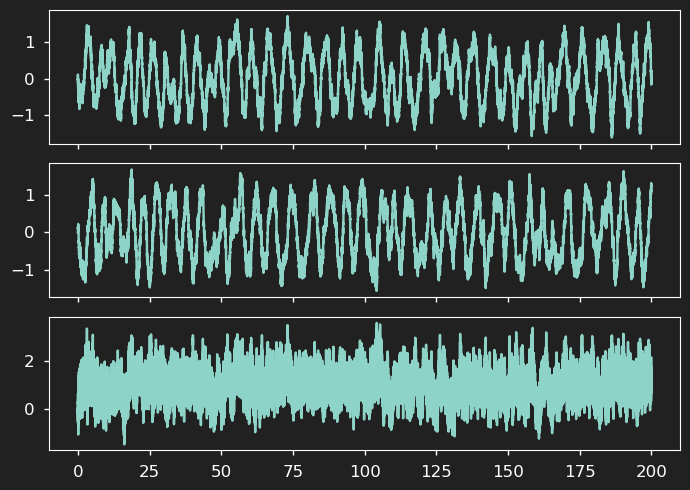

In [7]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

In [8]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

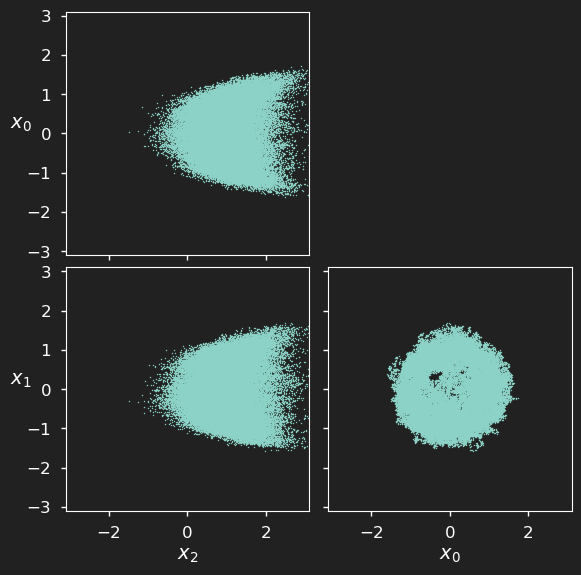

In [9]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, path, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

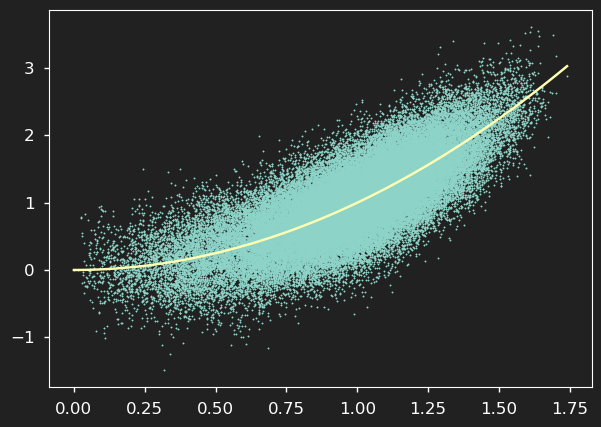

In [10]:
x, y, z = path.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1)

r_max = np.max(r)
r_lin = np.linspace(0, r_max, 100)
plt.plot(r_lin, r_lin**2, c='C1')

plt.show()

# Training dataset

In [11]:
train_ds = dataset(root / 'data')
train_data = train_ds.data.numpy()

In [12]:
np.any(train_ds == np.nan)

False

In [13]:
len(train_ds)

2978

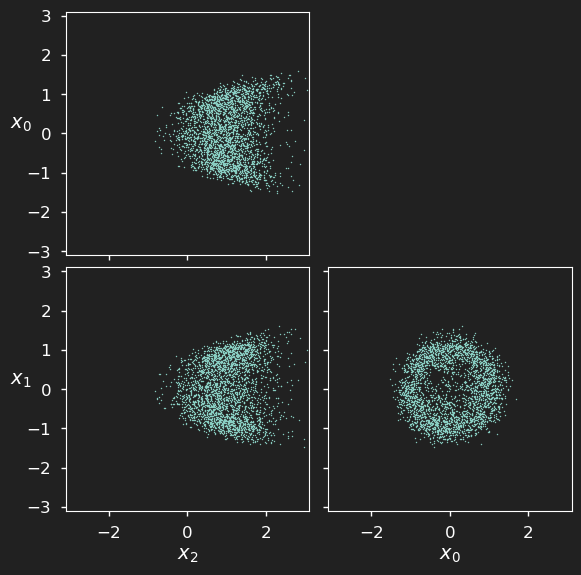

In [14]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, train_data, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

## Timescale separation

In [15]:
covis = np.array([covi.detach().numpy() for dp, covi, proj in train_ds])
covis.shape

(2978, 3, 3)

In [16]:
data_evals, data_evecs = zip(*[np.linalg.eigh(covi) for covi in covis])  # zip(*...) is equiv to transposing :)
data_evals, data_evecs = np.array(data_evals), np.array(data_evecs)

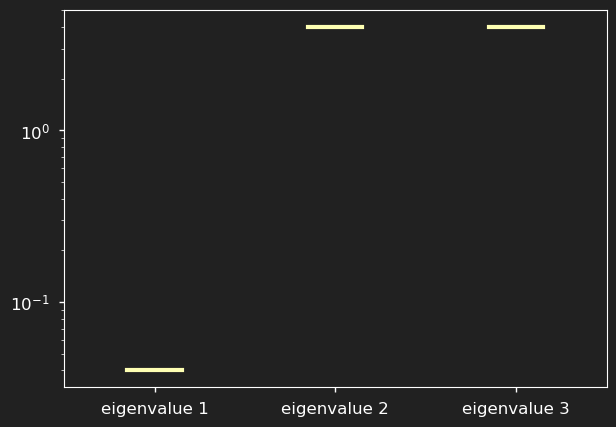

In [17]:
plt.boxplot(data_evals,
            labels=[f"eigenvalue {n+1}" for n in range(data_evals.shape[1])],
            medianprops={'lw': 3})
plt.yscale('log');

## Projection

In [18]:
slow_proj = train_ds.slow_proj
slow_proj.size()

torch.Size([2978, 3])

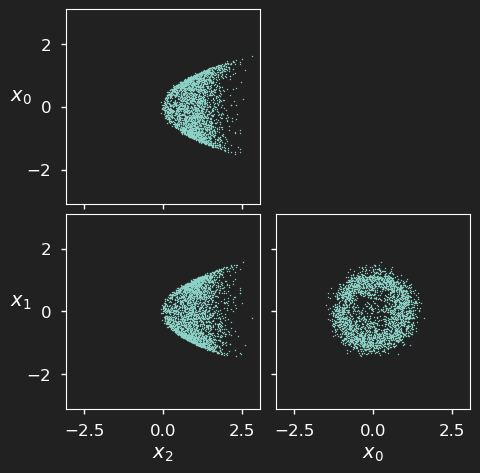

In [19]:
fig = plt.figure(figsize=(8,8))

gs = coord_grid(fig, slow_proj, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

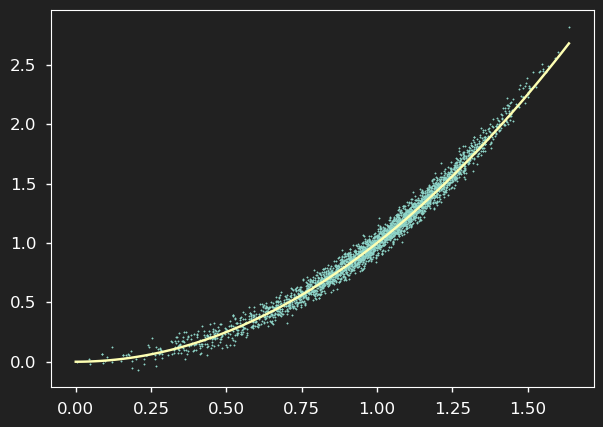

In [20]:
x, y, z = slow_proj.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1);

r_max = torch.max(r)
r_lin = np.linspace(0, r_max, 100)
plt.plot(r_lin, r_lin**2, c='C1');

# Models

In [25]:
model_types = ['mse']

In [26]:
series_list = []
for file in os.listdir(model_path):
    fpath = Path(file)
    if fpath.suffix == '.pt' and any(mt in fpath.stem for mt in model_types):
        model_data = torch.load(model_path / fpath.name)
        par_dict = {
            key:val
            for key, val in model_data['info']['config'].items()
            if key in {'max_epochs'}
        }
#         par_dict['layers (i,l,[h])'] = model_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = model_data['info']['config']['loader']['train_size']
#         par_dict['valid_size'] = model_data['info']['config']['loader']['valid_size']
        par_dict['features'] = model_data['info'].get('features', [])
        pruning = model_data['info']['config'].get('pruning')
#         par_dict['sparsity'] = model_data['best']['sparsity'] if pruning else 0.0
        best_epoch_idx = model_data['best']['epoch']-1
        par_dict['best_epoch'] = best_epoch_idx
        par_dict['valid_loss'] = model_data['history']['valid_losses'][best_epoch_idx]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
(
models_df.set_index('model_id')
         .sort_values(by='model_id')
         .style.format({
             'sparsity': '{0:.0%}',
             'valid_loss': '{:.2}',
             'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
             'burst_dt': '{:.0e}',
             'burst_size': '{:.0e}'
         })
         .set_properties(**{'font-size': '12pt',})
)

,max_epochs,features,best_epoch,valid_loss
model_id,,,,
mse_elu_1,1000,"[3, 4, 4, 2, 4, 4, 3]",993,0.00046


In [27]:
model_id = 'mse_elu_1'
model_data = torch.load(f'../results/models/{name_ds}/{model_id}.pt')

In [28]:
model = models.MahalanobisAutoencoder(**model_data['info']['arguments'])
model_dict = 'model_dict'
model.eval()

MahalanobisAutoencoder(
  (encoder): Sequential(
    (layer1): Linear(in_features=3, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (layer1): Linear(in_features=2, out_features=4, bias=True)
    (activation1): ELU(alpha=1.0)
    (layer2): Linear(in_features=4, out_features=4, bias=True)
    (activation2): ELU(alpha=1.0)
    (layer3): Linear(in_features=4, out_features=3, bias=True)
  )
  (mah_loss): MahalanobisLoss()
  (proj_loss): MSELoss()
)

### Training history

In [29]:
train_losses = model_data['history']['train_losses']
valid_losses = model_data['history']['valid_losses']
checkpoints = model_data['history']['checkpoints']
epochs = range(1, model_data['info']['config']['max_epochs']+1)
best_epoch = model_data['best']['epoch']

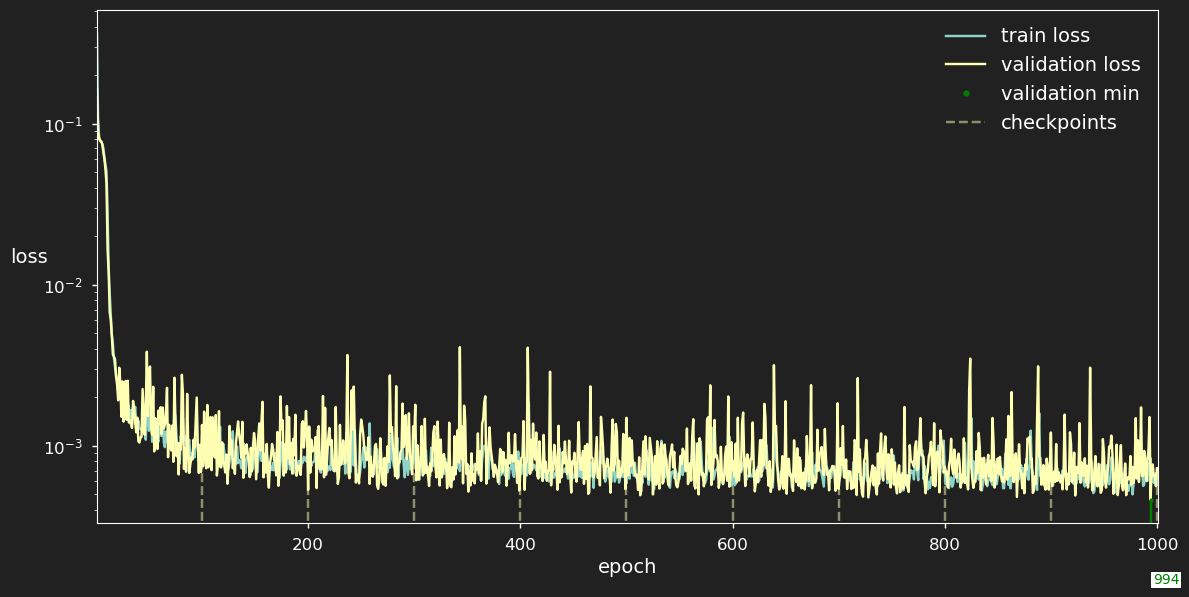

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
smallest_loss = valid_losses[best_epoch-1]
plt.vlines(x=best_epoch, ymin=0, ymax=smallest_loss, color='g')
ax.plot(best_epoch, smallest_loss, 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch+2, .3*smallest_loss, f'{best_epoch}', rotation=0, color='g', bbox={'fc': 'w', 'ec':'None', 'boxstyle':'Square, pad=0.1'})

ax.set_xlim([epochs[0], epochs[-1]+1])
# ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids[1::2])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)

ax.set_yscale('log')
ax.legend()

fig.tight_layout()
# fig.savefig(root / f"results/figs/{name_ds}/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [31]:
insp_epoch = 'best'

In [32]:
if insp_epoch == 'best':
    state_dict = model_data['best']['model_dict']
    insp_epoch = model_data['best']['epoch']
else:
    check_dict = torch.load(f'../results/models/{name_ds}/{model_id}/state_at_{insp_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])

In [33]:
model.load_state_dict(state_dict)
model.eval();

## Reconstruction visualization

In [34]:
test_ds = dataset(root / 'data', train=False)
len(test_ds)

1467

In [42]:
test_data = test_ds.data
test_data_np = test_data.detach().numpy()
test_slow = test_ds.slow_proj
# test_data_np = test_data.detach().numpy()

In [43]:
with torch.no_grad():
    test_rec = model(test_data)
# test_rec_np = test_rec.detach().numpy()

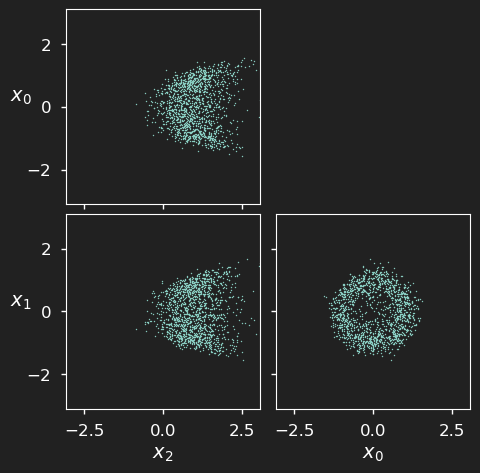

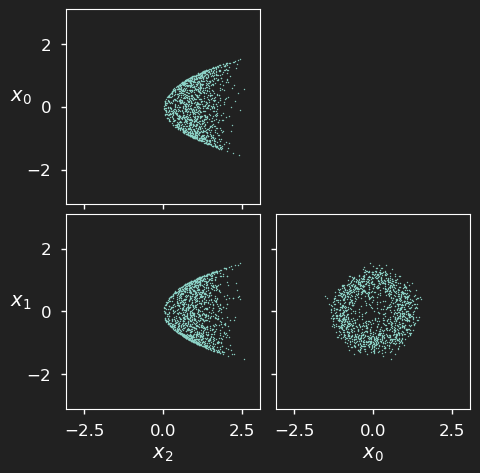

In [44]:
fig = plt.figure(figsize=(8,8))
gs = coord_grid(fig, test_data, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

fig = plt.figure(figsize=(8,8))
gs = coord_grid(fig, test_rec, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

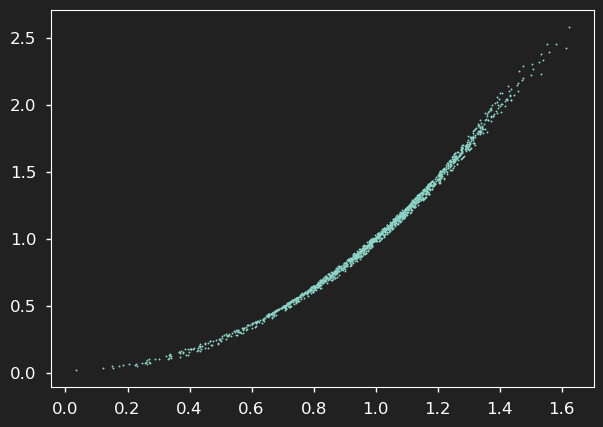

In [45]:
x, y, z = test_rec.T
r = np.sqrt(x**2 + y**2)

plt.scatter(r, z, s=1);

In [46]:
slow_map = test_ds.system.slow_map

In [48]:
slow_var = slow_map(test_data_np.T)

In [49]:
with torch.no_grad():
    lat_var = model.encoder(test_data).T
lat_var.shape

torch.Size([2, 1467])

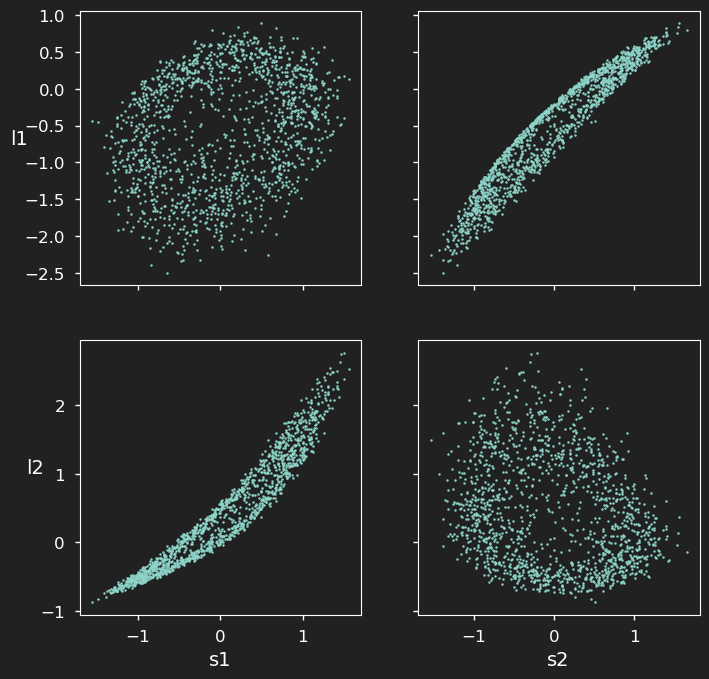

In [50]:
sdim = test_ds.system.sdim
fig, axs = plt.subplots(ncols=sdim, nrows=sdim, figsize=(8,8), sharey='row', sharex='col')
for m, slow_coord in enumerate(slow_var):
    for n, lat_coord in enumerate(lat_var):
        axs[n,m].scatter(slow_coord, lat_coord, s=2)
        if n + 1 == sdim:
            axs[n,m].set_xlabel(f"s{m+1}")
        if m == 0:
            axs[n,m].set_ylabel(f"l{n+1}", rotation=0)

## Encoder: level sets

In [51]:
def to_darray(*meshgrids):
    return np.stack(meshgrids).reshape(len(meshgrids), -1).T

def to_grid(darray, grid_size):
    if darray.ndim == 1:
        return darray.reshape(grid_size, -1)
    else:
        return darray.reshape(darray.shape[1], grid_size, -1)

In [62]:
mesh_size = 300
x = np.linspace(-2.5, 2.5, mesh_size)
y = np.linspace(-2.5, 2.5, mesh_size)
z = np.linspace(-1.0, 3.0, mesh_size)

In [68]:
X, Y, Z = np.meshgrid(x, y, z)
R = np.sqrt(X**2 + Y**2)

In [69]:
mesh_data = torch.tensor(to_darray(X, Y, Z), dtype=torch.float)
mesh_data.shape

torch.Size([27000000, 3])

In [70]:
with torch.no_grad():
    w = model.encoder(mesh_data)
w.size()

torch.Size([27000000, 2])

In [71]:
W = torch.squeeze(to_grid(w, mesh_size))
W.size()

torch.Size([2, 300, 90000])

In [762]:
zz = slow_map(mesh_data.numpy().T).T
ZZ = np.squeeze(to_grid(zz, mesh_size))

TypeError: Inputs x and y must be 1D or 2D, not 3D

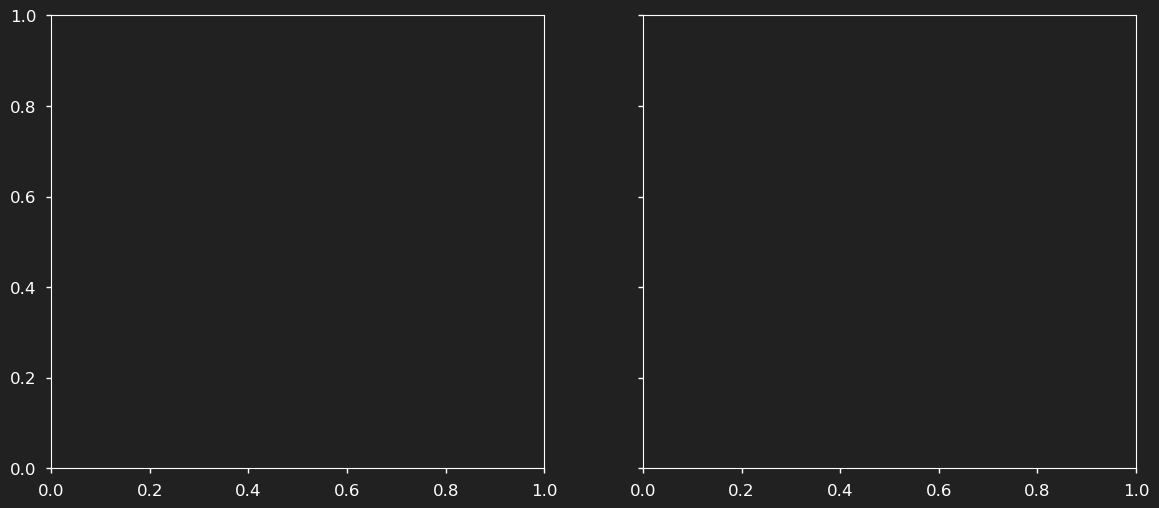

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(14,6), sharey=True)
cntr = axs[0].contour(R, Z, W[0], levels=np.linspace(-6, 6, 50))
# axs[0].colorbar(cntr, ax=ax)

v = np.linspace(.8, 1.2, 100)
for u0 in np.linspace(-0.3*np.pi, 1.0*np.pi, 10):
    axs[0].plot(v*np.cos(u0-1 + v), v*np.sin(u0-1 + v), c='C1')

# axs[0].scatter(*train_data_np.T)

# cntr = axs[1].contour(X, Y, ZZ, levels=50)
# fig.colorbar(cntr, ax=ax)

plt.show(fig)
plt.close(fig)
